<a href="https://www.kaggle.com/code/liamwander/siim-isic-melanoma-classification-wander?scriptVersionId=132558305" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# SIIM-ISIC Melanoma Classification
## Binary Classification Projektarbeit vom 22.05. bis 06.06.2023 ~ Liam Wander

### Auftrag
- Erstellen Sie eine kurze explorative Datenanalyse zur train.csv um erste Einsichten zu gewinnen. Auffälligkeiten bitte in kurzer Form im Markdown notieren.
- Erstellen Sie ein Pytorch-Dataset, in dem Sie die Bilder und tabularen Daten zusammenfassen. Das Dataset wird drei(!) Dinge zurückgeben (das Bild, die passende Zeile aus dem Dataframe sowie das Target)
- Erstellen Sie ein Pytorch-Modell, welches ausschließlich aufgrund der Bilder klassifiziert.
- Testen Sie das Modell mit einem Sample
- Trainieren Sie das Modell und geben Sie die Accuracy sowie den F1-Score aus
- Kombinieren Sie nun tabulare Daten und Bilder: Erstellen Sie ein weiteres Pytorch-Modell welches das Bild UND die tabularen Daten verarbeiten kann. (Tipp: die Forward-Methode bekommt hier das Bild sowie die passende Zeile aus dem Dataframe übergeben, es handelt sich hier um ein Multimodales-Modell)
- Halten Sie ihr Vorgehen in Form eines (kurzen, gerne auch stichwortartigen) Protokolls im Markdown fest. Gehen Sie auch auf Probleme und Sackgassen ein!
- Beide Modelle sollen eine submission erstellen!

### Tipps:

- Da hier einiges neu ist (multimodales Modell z.B.): nutzen Sie copilot, chatgpt und das Internet um herauszufinden, wie Sie das Problem angehen. 
- Das Dataset ist unbalanced, das ist ein Problem welches Sie lösen müssen
- EfficientNet dürfen auch benutzt werden, sie sind kleiner und leistungsfähiger als resnets → https://pytorch.org/hub/nvidia_deeplearningexamples_efficientnet/

https://www.statology.org/label-encoding-vs-one-hot-encoding/ OHE statt LabelEncoding, da LE eine scheinbare Gewichtung erzeugt

https://www.statology.org/dummy-variable-trap/

In [1]:
!pip install validators matplotlib
!pip install pytorch-lightning''
!pip install efficientnet_pytorch
!pip install ipywidgets

  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=3ebd1ea488f4ca59de9e140b83810754961ae9638ec85c1aa3b16fd9a799a7ab
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=ad9790923c8b26c8ddafb8fe27dd070753fa891c6dcd508b618dd8ba35008135
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import json
import requests
import warnings
warnings.filterwarnings('ignore')

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger # loggers instead of logging
%load_ext tensorboard
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.tuner.tuning import Tuner
from efficientnet_pytorch import EfficientNet

import torch, os, torchvision
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.utils import resample # resampling unbalanced data
from sklearn.preprocessing import OneHotEncoder
# import roc_curve
from sklearn.metrics import roc_curve, auc
from keras.callbacks import History

train_image_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train'
test_image_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/test'

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = 'cpu'
print(f'Using {device}')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using cpu


# Explorative Datenanalyse

In [3]:
train_data = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
test_data = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')

In [4]:
train_data[:5]

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [5]:
test_data[:5]

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


train.csv enthält mehrere NaN-Werte in den Attributen sex, age_approx und anatom_site_general_challenge

In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10982 non-null  object 
 1   patient_id                     10982 non-null  object 
 2   sex                            10982 non-null  object 
 3   age_approx                     10982 non-null  float64
 4   anatom_site_general_challenge  10631 non-null  object 
dtypes: float64(1), object(4)
memory usage: 429.1+ KB


In [8]:
train_data['sex'].unique()

array(['male', 'female', nan], dtype=object)

In [9]:
train_data['age_approx'].unique()

array([45., 50., 55., 40., 25., 35., 30., 75., 70., 65., 60., nan, 80.,
       20., 85., 15., 90., 10.,  0.])

In [10]:
train_data['age_approx'].describe()

count    33058.000000
mean        48.870016
std         14.380360
min          0.000000
25%         40.000000
50%         50.000000
75%         60.000000
max         90.000000
Name: age_approx, dtype: float64

Die NaN Werte des numerischen Tupels ```age_approx``` werden aufgrund der Extremen mit dem Median ersetzt (50%=50)

In [11]:
train_data['age_approx'].fillna(50,inplace = True)

In [12]:
train_data.iloc[:,4].unique()

array(['head/neck', 'upper extremity', 'lower extremity', 'torso', nan,
       'palms/soles', 'oral/genital'], dtype=object)

In [13]:
train_data.iloc[:,4].fillna('unknown', inplace = True)
test_data.iloc[:,4].fillna('unknown', inplace = True)

In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33126 non-null  float64
 4   anatom_site_general_challenge  33126 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


<AxesSubplot: >

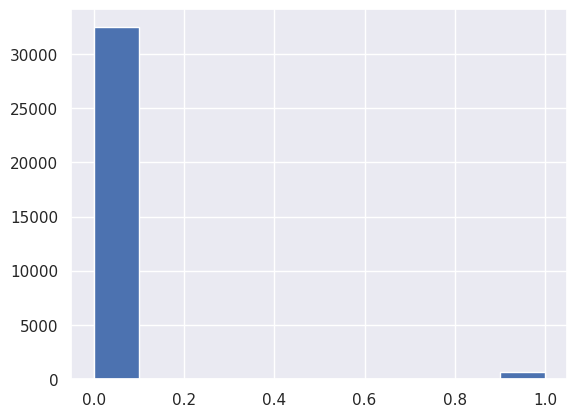

In [15]:
train_data['target'].hist()

-> Bewahrheitete Erkenntnis: moderat unausgeglichene Daten unter ```target``` im Datensatz!

Möglichkeiten zur "Korrektur":
- Nutzung anderer Performance Indikatoren
- Resampling und gewichten
    - 1. Downsampling: das Training mit einer unverhältnismäßig kleinen Teilmenge der Beispiele aus der Mehrheitsklasse.
    - 2. Bei der Gewichtung wird der Downsampling-Klasse eine Beispielgewichtung hinzugefügt, die dem Faktor entspricht, um den das Downsampling durchgeführt wurde
- Synthetische Datensätze in der Minderklasse bereitstellen

# Downsampling
### Kategorische Daten über OHE einer Klasse zuweisen und target=0 downsamplen sowie gewichten

Die einzelnen Tupel sind nicht numerisch, sondern als Object gespeichert. Damit diese im weiteren Vorgehen analysierbar und verwertbar sind, bedarf es eines Label Encodings. Sprich als nächsten Schritt gilt es gleiche Objekte einer Klasse zuzuweisen.

In [16]:
df_majority = train_data[train_data['target'] == 0] # benign
df_minority = train_data[train_data['target'] == 1] # malign

In [17]:
len(df_minority)/len(df_majority)*100

1.7946038965029807

Die maligne Klasse ist nur 1,8% so groß wie die benigne Klasse, demnach ist das Trainings-Datenset mäßig unausgeglichen. Das wird geändert indem zufällig die Klasse benign um den Faktor 20 gekürzt wird. 

In [18]:
# downsample majority class
df_downsampled = resample(df_majority,
             replace=True,
             n_samples=int(len(df_majority)/20), # -95%
             random_state=42)

print(df_downsampled.shape)

(1627, 8)


In [19]:
df_downsampled.target.value_counts()
df_downsampled['target'].value_counts()
df_downsampled['target'].value_counts(normalize=True)

0    1.0
Name: target, dtype: float64

In [20]:
# combine minority class with downsampled majority class
df_downsampled = pd.concat([df_downsampled, df_minority])
df_downsampled = df_downsampled.sample(frac=1).reset_index(drop=True) # random shuffle

In [21]:
# example_weight = original_example_weight * downsampling_factor
#class_weight = (df_majority / len(df_majority)+len(df_minority)) / (int( len(df_majority)) / int( len(df_majority)+len(df_minority) ))
df_downsampled['weight']=np.where(df_downsampled['target']==1,(len(df_majority)/len(train_data)) / (len(df_minority) / len(df_minority) *2), (len(df_minority) / len(train_data)) / (len(df_minority) / len(df_minority) *2))


<AxesSubplot: >

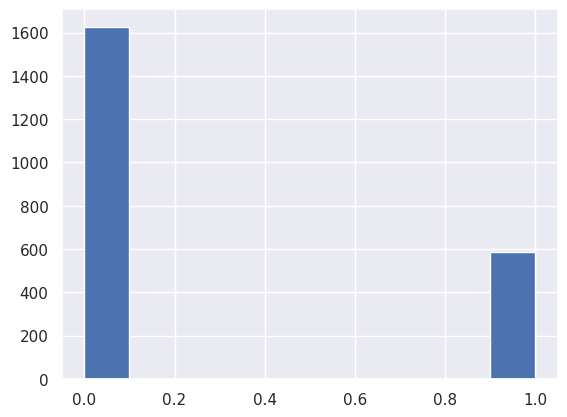

In [22]:
# reduce the size of the dataset
# df_downsampled = df_downsampled.sample(frac=0.1).reset_index(drop=True) # random shuffle
df_downsampled['target'].hist()

In [23]:
df_downsampled.shape

(2211, 9)

### Warum Downsampling und Gewichtung?
Es mag seltsam erscheinen, nach  Sampling Stichprobengewichtungen hinzuzufügen. Wir haben versucht, unser Modell für die Minderheitenklasse zu verbessern. Warum sollten wir die Mehrheit höher gewichten? Das sind die Änderungen:

- Schnellere Konvergenz: Während des Trainings sehen wir die Minderheitsklasse häufiger, wodurch das Modell schneller konvergiert wird.
- Laufwerksspeicher: Wenn Sie die Mehrheitsklasse in weniger Beispielen mit größerer Gewichtung konsolidieren, sparen wir weniger Speicherplatz. Diese Einsparungen ermöglichen mehr Speicherplatz für die Minderheitsklasse, sodass wir eine größere Anzahl und eine größere Auswahl an Beispielen aus dieser Klasse erfassen können.
- Kalibrierung: Durch die Gewichtung erfolgt die Kalibrierung unseres Modells. Die Ausgaben können trotzdem als Wahrscheinlichkeiten interpretiert werden.

##### TODO -> realisiert in den PyTorch.Lightning Modellen als Loss(?)
```
import torch

x = torch.rand(8, 4)
# Ground truth
y = torch.randint(2, (8,))
# Weights per sample 
weights = torch.rand(8, 1) 

# Add weights as a columns, so that it will be passed trough
# dataloaders in case you want to use one
x = torch.cat((x, weights), dim=1)

model = torch.nn.Linear(4, 2)

loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
def weighted_loss(y, y_hat, w):
  return (loss_fn(y, y_hat)*w).mean()

loss = weighted_loss(model(x[:, :-1]), y, x[:, -1])
print (loss)
```

In [24]:
# replace one sex entry in test_data with NaN to be able to perform one hot encoding hastily
test_data['sex'][0] = np.nan

In [25]:
categorical = ['sex', 'anatom_site_general_challenge']
cat_to_be_deleted = ['diagnosis', 'benign_malignant'] # sind nicht realistisch in test daten vorhanden! -> schwierig damit ein Netz zu trainieren, es sei denn man will 3 Targets haben
categorical_cols_train = []
categorical_cols_test = []

for col in categorical:
    categorical_cols_train += [f"{col[0]}_{val}" for val in train_data[col].unique()]
    
for col in categorical:
    categorical_cols_test += [f"{col[0]}_{val}" for val in test_data[col].unique()]

print(categorical_cols_train)
print(categorical_cols_test)
# create the encoder object
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# fit and transform the categorical variables.
final_train = pd.DataFrame(encoder.fit_transform(df_downsampled[categorical]),
                          index=df_downsampled.index, columns=categorical_cols_train)

final_train.insert(0, 'image_name', df_downsampled['image_name'])
final_train.insert(1, 'patient_id', df_downsampled['patient_id'])

final_test = pd.DataFrame(encoder.transform(test_data[categorical]),
                            index=test_data.index, columns=categorical_cols_train)
final_test.insert(0, 'image_name', test_data['image_name'])
final_test.insert(1, 'patient_id', test_data['patient_id'])

# add age column
final_train.insert(2, 'age_approx', df_downsampled['age_approx'])
final_test.insert(2, 'age_approx', test_data['age_approx'])
final_train['target'] = df_downsampled['target'] # Needed to create the correct ImageTargetDataset!

#final_train['weight'] = np.where(final_train['target']==1,(len(df_majority)/len(train_data)) / (len(df_minority) / len(df_minority) *2), (len(df_minority) / len(train_data)) / (len(df_minority) / len(df_minority) *2))
#final_test['weight'] = no target col. setting to 0 wouldnt make any sense
print(final_train) # using df_downsampled instead of train_data
print(final_test)

['s_male', 's_female', 's_nan', 'a_head/neck', 'a_upper extremity', 'a_lower extremity', 'a_torso', 'a_unknown', 'a_palms/soles', 'a_oral/genital']
['s_nan', 's_male', 's_female', 'a_unknown', 'a_lower extremity', 'a_torso', 'a_upper extremity', 'a_head/neck', 'a_palms/soles', 'a_oral/genital']
        image_name  patient_id  age_approx  s_male  s_female  s_nan  \
0     ISIC_4530249  IP_9087899        40.0     0.0       1.0    0.0   
1     ISIC_0744013  IP_6204577        65.0     1.0       0.0    0.0   
2     ISIC_1694480  IP_9513376        35.0     0.0       1.0    0.0   
3     ISIC_0427813  IP_6486706        50.0     0.0       1.0    0.0   
4     ISIC_7410175  IP_6008814        90.0     1.0       0.0    0.0   
...            ...         ...         ...     ...       ...    ...   
2206  ISIC_7398145  IP_7685109        25.0     1.0       0.0    0.0   
2207  ISIC_7074321  IP_2320445        50.0     1.0       0.0    0.0   
2208  ISIC_7270945  IP_2285751        45.0     1.0       0.0    0

Nun haben wir zwei Binärkodierte Datensätze, die vielleicht mehr in einer kurzen explorativen Datenanalyse aussagen können.
EDIT vom 01.06.: Das Dataset setzt sich nun aus dem df_downsampled (2200 entries) statt den train_data (33000 entries) zusammen!
macht das Training um einiges schneller

<AxesSubplot: >

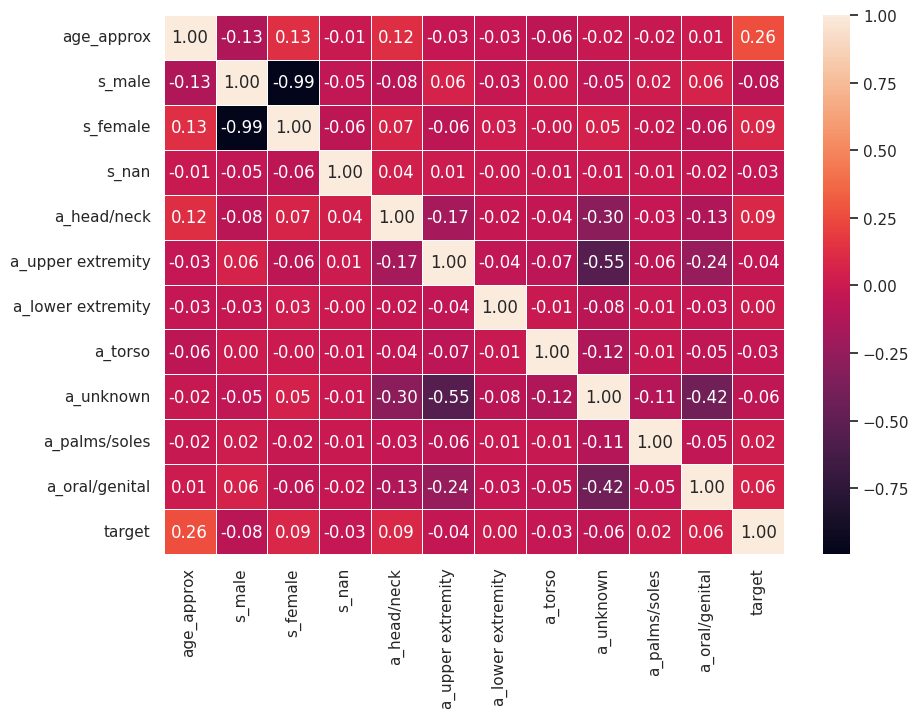

In [26]:
corr = final_train.corr()
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corr, annot=True, fmt=".2f", linewidths=.5)

Der Körperbereich "unbekannt" korrelliert mäßig negativ mit dem Körperbereich der Oberen Extremität -> Letzteres, genauso wie der Genitalbereich scheint am häufigsten vorzukommen - bzw. wo unerwünschte Hautveränderungen bemerkt werden(?)
Außerdem: Wer kein Mann ist, ist eine Frau - und vice versa.

# Creating a DataSet that contains the Images, Data Entries and Targets
Constructing own Python Dataset, which inherits most of its features from the module Dataset:

später vielleicht von pl.LightningDataModule erben, um das Dataset zu vereinfachen und Probleme mit der GPU zu vermeiden

PyTorch Lightning: 
- LightningModule als Basis für das Modell (statt nn.Module)
- LightningDataModule als Basis für das Dataset (statt Dataset)
- Trainer als Basis für das Training (statt eigener Trainingsloop)
- Output der Modelle in forward method
- configure_optimizers für Optimierung und Scheduler
- training_step für Berechnung und Rückgabe des Loss (alles andere wie Berechnung des Gradienten, Aktualisierung der Parameter und Geräteeinstellung wird von Lightning gehandhabt)
- validation_step ähnlich wie training_step, nur für die Validierung
- Logging mit .log


In [27]:
class ImageTargetDataset(Dataset):
    '''Image, Tabular and Target dataset.'''
    def __init__(self, dataframe, image_dir, transform=None):
        self.tabular_data = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.tabular_data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        tabular_data = self.tabular_data.iloc[idx, 0:]

        y = tabular_data['target']
        y = torch.tensor(y, dtype=torch.float32) # convert to tensor

        image = Image.open(f"{self.image_dir}/{tabular_data['image_name']}.jpg")
        image = image.convert('RGB')
        image = np.array(image)
        image = image[..., :3] 
        
        if self.transform:
            image = self.transform(image)

        tabular_data = tabular_data[['s_male', 's_female', 's_nan', 'a_head/neck', 'a_upper extremity', 'a_lower extremity', 'a_torso', 'a_unknown', 'a_palms/soles', 'a_oral/genital', 'age_approx']]# 'weight']]
        tabular_data = tabular_data.tolist()
        tabular_data = torch.FloatTensor(tabular_data)
        
        return image, tabular_data, y

Abschließend liegt ein 3-dimensionaler Datensatz vor, welcher uns je ein Bild, das dazugehörige Datum im Binärformat und das Target zurückgibt.
Die Bilder sind in der Größe 224x224 Pixel und werden mit der Funktion ```transforms.ToTensor()``` in ein Tensor-Objekt umgewandelt. Die Daten werden mit ```torch.from_numpy()``` in ein Tensor-Objekt umgewandelt. Die Targets sind in der Größe 1x1 und werden mit ```torch.tensor()``` in ein Tensor-Objekt umgewandelt. 

TODO: Mit PyTorch Lightning DataModule vereinfachen und GPU Probleme vermeiden

# Creating a PyTorch Model that classifies the Target based solely on the images
Später vielleicht mit PyTorch Lightning vergleichen? 
Edit 05.06.: Ist mit PyTorch Lightning realisiert worden, nur ohne Datamodule

Inspiration:

https://towardsdatascience.com/from-pytorch-to-pytorch-lightning-a-gentle-introduction-b371b7caaf09

https://lightning.ai/docs/pytorch/stable/model/train_model_basic.html

https://lightning.ai/docs/pytorch/latest/

In [28]:
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
# impot binary cross entropy loss
from torch.nn import BCEWithLogitsLoss

class ImageEfficientNet(pl.LightningModule):
    def __init__(self, num_classes, lr=1e-4):
        super().__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0')
        # images are RGB, so 3 channels and the size is 224x224
        self.model._conv_stem = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        self.model._fc = nn.Linear(in_features=1280, out_features=num_classes, bias=True)
        self.lr = lr

    def forward(self, image):
        out = self.model(image)
        print(out.shape)
        return out

    def cross_entropy_loss(self, logits, labels):
        loss = BCEWithLogitsLoss()
        return loss(logits, labels)    

    
    def training_step(self, train_batch, batch_idx):
        image, _, target = train_batch
        y_hat = self.forward(image).to(device) 
        loss = self.cross_entropy_loss(y_hat, target.unsqueeze(1).float())
        accuracy = (y_hat.argmax(dim=1) == target).float().mean()

        tensorboard_logs = {'train_loss': loss, 'train_acc': accuracy}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def test_step(self, batch, batch_idx):
        image, _, target = batch
        y_hat = self.forward(image).to(device)
        loss = self.cross_entropy_loss(y_hat, target.unsqueeze(1).float())
        accuracy = (y_hat.argmax(dim=1) == target).float().mean()

        tensorboard_logs = {'test_loss': loss, 'test_acc': accuracy}
        return {'test_loss': loss, 'log': tensorboard_logs}
    
    # test epoch end should return target
    def test_epoch_end(self, outputs):
        y_hat = torch.cat([x['y_hat'] for x in outputs], dim=0)
        test_data['target'] = y_hat.tolist()
        test_data.target.to_csv('submission_images.csv', index=False)  # predict and save to csv?
        return {'test_loss': torch.stack([x['test_loss'] for x in outputs]).mean()}
        
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 37.6MB/s]


Loaded pretrained weights for efficientnet-b0


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])


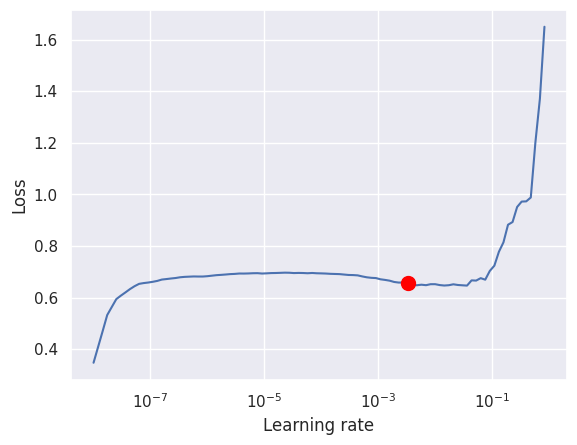

0.003311311214825908


Training: 0it [00:00, ?it/s]

torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])


In [29]:
X_train, X_test, y_train, y_test = train_test_split(final_train, final_train['target'], test_size=0.2, random_state=42)

train_dataset = ImageTargetDataset(X_train, train_image_path, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(20),
            transforms.RandomAffine(20),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
        ))

test_dataset = ImageTargetDataset(X_test, train_image_path, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(20),
            transforms.RandomAffine(20),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
        ))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

if __name__ == '__main__':
    logger = TensorBoardLogger('lightning_logs', name='image_classification')
    checkpoint_callback = pl.callbacks.ModelCheckpoint('{epoch:02d}-{val_loss:.4f}', monitor='val_loss', mode='min', save_top_k=3)
    model = ImageEfficientNet(num_classes=1)
    trainer = pl.Trainer(max_epochs=2, logger=logger, callbacks=[checkpoint_callback])
    tuner = Tuner(trainer)
    lr_finder = tuner.lr_find(model, train_loader, test_loader)
    fig = lr_finder.plot(suggest=True, show=True)
    new_lr = lr_finder.suggestion()
    print(new_lr)
    model.hparams.lr = new_lr
    trainer.fit(model, train_loader, test_loader)

In [ ]:
# convert this to a function
def predict_image(image):
    image = image.convert('RGB')
    image = np.array(image)
    image = image[..., :3]
    image = transforms.ToTensor()(image)
    image = transforms.Resize((224, 224))(image)
    image = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(image)
    image = image.unsqueeze(0)
    image = image.to(device)
    
    with torch.no_grad():
        model.eval()
        y_test_pred = model(image)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        print(y_pred_tags.cpu().numpy())
        
    plt.imshow(image.squeeze().cpu().permute(1, 2, 0))
    plt.title(f'Predicted label: {y_pred_tags.cpu().numpy()} with probability: {torch.exp(y_pred_softmax).cpu().numpy()[0][y_pred_tags.cpu().numpy()]}')
    plt.show()

# use a for loop for 3 images
for i in range(3):
    image = Image.open(f"{train_image_path}/{final_train['image_name'][i]}.jpg")
    predict_image(image)

Nachdem der Datensatz von train_data (33000E) zu df_downsampled (2200E) gewechselt wurde, geht das Training deutlich schneller als ~4h für eine Epoche. Nun dauert eine Epoche nur etwa 10 Minuten, und die maximale Anzahl dieser wurde von 3 auf 10 hochgesetzt.

01.06.2023 @ 18:50 - mit einem CUDA / GPU Device bekomme ich die Fehlermeldung dass weights nicht von der GPU gelesen werden.

```RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same```

Werde das ganze in einer CPU-Umgebung testen um den genauen Fehker zu ermitteln.

Stand 02.06.2023 @ 16:30 - Nachdem ich vergeblich mit einem PyTorch Datamodule versucht habe den Fehler auszumerzen, habe ich die Hardwarebeschleunigung deaktiviert und lasse nun mit der CPU rechnen. Mit dieser Umgebungsvariable begegne ich keinerlei Fehlern. Ich vermute, bestimmte sinnfreie ```.to(device)``` Attribute innerhalb des EfficientNet und PyTorch Lightning Klassengebilde verursachen diesen Fehler. Das Modell und die Daten selbst habe ich sonst explizit auf .cuda geschoben, bzw. jetzt auskommentiert in der CPU Umgebung.

Ich bin mir nicht ganz sicher wie & wo (oder ob) die folgende "Lösung" sinnvoll eingesetzt werden kann, schließlich habe ich das mehr oder minder bereits genau so versucht. Zumindest denke ich das. 

https://stackoverflow.com/a/59013131

Außerdem muss ich das Konzept mit den final_train['weights'], sprich die Übergewichtung einzelner Tupel der Mehrheitsklasse (und nicht der gesamten Klasse) noch berücksichtigen - UND sinnvoll für das EfficientNet einbauen.

In [30]:
%%time
for _ in range(3):
    trainer.test(model, dataloaders=test_loader, ckpt_path='best')

ValueError: `.test(ckpt_path="best")` is set but `ModelCheckpoint` is not configured to save the best model.

In [32]:
from glob import glob
submission = test_data[['target']]
submission.target = 0.0
for sub in glob('submission*.csv'):
    submission.target += pd.read_csv(sub, index_col='image_name').target

submission.target -= submission.target.min()
submission.target /= submission.target.max()

submission.to_csv('submission_images.csv')

submission.hist(bins=100, log=True, alpha=0.75)

KeyError: "None of [Index(['target'], dtype='object')] are in the [columns]"

# Creating a PyTorch (Lightning) model that classifies the Targets based on Images and Tabular Data

In [38]:
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc


# PyTorch Lightning
# define the EfficentNet model for the image and tabular data
class MultiModalEfficientNet(pl.LightningModule):
    '''PyTorch Lightning module for the EfficientNet model, for a binary classification problem.'''
    '''Learning from Images and Tabular Data.'''
    def __init__(self, num_classes, lr=1e-4):
        super().__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0')
        # images are RGB encoded, so 3 channels and the size is 224x224
        self.model._conv_stem = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        self.model._fc = nn.Linear(in_features=1280, out_features=1280, bias=True)
        self.tabular_model = nn.Sequential(
            nn.Linear(1280 + 11, 1280),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1280, 1280),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1280, 1),
            nn.Sigmoid()
        )
        self.lr = lr

    def forward(self, image, tabular_data):
        out = self.model(image) # pass the image through the EfficientNet model
        out = torch.cat((out, tabular_data), dim=1) # concatenate the flattened output with the tabular data
        out = self.tabular_model(out) # pass the output through the tabular model
        # print(out.requires_grad)
        return out
    
    def training_step(self, batch, batch_idx):
        image, tabular, y = batch

        # criterion = nn.L1Loss()
        y_pred = torch.flatten(self(image, tabular)) 
        # weighted loss of each sample 
        # loss = F.binary_cross_entropy(y_pred, y, weight=tabular[:, 10]) # weight is the last column of the tabular data
        loss = F.binary_cross_entropy(y_pred, y)

        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def test_step(self, batch, batch_idx):
        image, tabular, y = batch

        # criterion = nn.L1Loss()
        y_pred = torch.flatten(self(image, tabular)) 
        # weighted loss of each sample
        # test_loss = F.binary_cross_entropy(y_pred, y, weight=tabular[:, 10]) # weight is the last column of the tabular data
        test_loss = F.binary_cross_entropy(y_pred, y)

        tensorboard_logs = {'test_loss': test_loss}
        return {'test_loss': test_loss, 'log': tensorboard_logs}
    
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_f1 = torch.stack([x['test_f1'] for x in outputs]).mean()
        avg_accuracy = torch.stack([x['test_accuracy'] for x in outputs]).mean()

        y_hat = torch.cat([x['y_hat'] for x in outputs], dim=0)
        test_data['target'] = y_hat.tolist()
        test_data.target.to_csv('submission_multi_modal.csv', index=False) # save the predictions to a csv file

        tensorboard_logs = {'test_loss': avg_loss, 'avg_test_f1': avg_f1, 'avg_test_accuracy': avg_accuracy}
        return {'test_loss': avg_loss, 'log': tensorboard_logs, 'progress_bar': tensorboard_logs}
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
# RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn
# A fix for this is to use torch.no_grad() when evaluating the model. 
# This will disable gradient calculation, which reduces memory usage and speeds up computation.
# So Here is the code for the training loop in PyTorch Lightning:
# def training_step(self, batch, batch_idx):
#     image, tabular, y = batch
#     y_pred = torch.flatten(self(image, tabular).detach()) # detach the output from the EfficientNet model <- this is not even slightly correct
#     y_pred = torch.unsqueeze(y_pred, 1) # add a dimension to the output to match the target shape
#     loss = F.binary_cross_entropy(y_pred, y)
#     tensorboard_logs = {'train_loss': loss}
#     return {'loss': loss, 'log': tensorboard_logs}

# def test_step(self, batch, batch_idx):
#     image, tabular, y = batch
#     y_pred = torch.flatten(self(image, tabular).detach()) # detach the output from the EfficientNet model <- this is not even slightly correct
#     y_pred = torch.unsqueeze(y_pred, 1) # add a dimension to the output to match the target shape
#     test_loss = F.binary_cross_entropy(y_pred, y)
#     return {'test_loss': test_loss}

# def test_epoch_end(self, outputs):
#     avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
#     logs = {'avg_test_loss': avg_loss}
#     return {'avg_test_loss': avg_loss, 'log': logs, 'progress_bar': logs}

# ValueError: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([1, 32])) is deprecated. Please ensure they have the same size.
# So unsqueeze is not needed anymore, because the output of the model is already flattened.

# RuntimeError: Early stopping conditioned on metric `avg_test_loss` which is not available. Pass in or modify your `EarlyStopping` callback to use any of the following: ``
# So the test_loss is not available, because the test_step is not returning it.

Loaded pretrained weights for efficientnet-b0


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

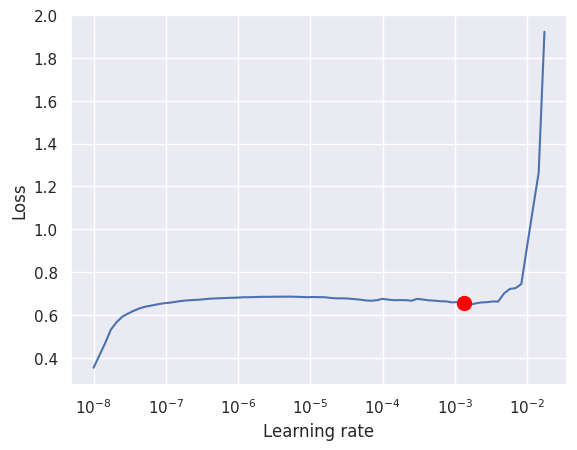

Training: 0it [00:00, ?it/s]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(final_train, final_train['target'], test_size=0.2, random_state=42)

train_dataset = ImageTargetDataset(X_train, train_image_path, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(20),
            transforms.RandomAffine(20),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
        ))

test_dataset = ImageTargetDataset(X_test, train_image_path, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(20),
            transforms.RandomAffine(20),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
        ))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

if __name__ == '__main__':
    logger = TensorBoardLogger('lightning_logs', name='multi-modal')
    #early_stop_callback = EarlyStopping(
    #    monitor='test_loss',
    #    min_delta=0.00,
    #    patience=3,
    #    verbose=False,
    #    mode='min'
    #)
    model = MultiModalEfficientNet(num_classes=1, lr=1e-3)
    trainer = pl.Trainer(max_epochs=10, logger=logger)#, callbacks=early_stop_callback)
    tuner = Tuner(trainer)
    lr_finder = tuner.lr_find(model, train_loader, test_loader)
    fig = lr_finder.plot(suggest=True, show=True)
    new_lr = lr_finder.suggestion()
    model.hparams.lr = new_lr
    trainer.fit(model, train_loader, test_loader)



```RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn```

in MultiModalEfficientNet.forward() hat out.requires_grad den Booleanwert True. Daran liegt scheinbar kein Problem. Die Funktion .detach() auf `y_pred = torch.flatten(self(image, tabular))` wird verworfen, da diese den Output vom Computation Graph loslöst/entfernt. -> Diese stupide Idee hat obenstehenden Fehler nach 1 Tag behoben. Kommentar: Fantastisch!
Nun noch ein paar Verbesserungen in der Metrikdarstellung und -betrachtung, sowie die Einbindung der Gewichtung einzelner Tupel der Mehrheitsklasse plus Submissions beider Modelle - dann ist das Notebook abgabebereit. Pluspunkt: Optimierung der Markdownstruktur!

```RuntimeError: Early stopping conditioned on metric `test_loss` which is not available. Pass in or modify your `EarlyStopping` callback to use any of the following: ```

Early stopping lasse ich so erstmal aussen vor. Den Fehler innerhalb dieses Features kann ich auf die schnelle nicht so beheben, dafür trainiert das Modell einwandfrei..

Insight: bei einer Lernrate von 10.5^-2 sind wir klar im Bereich des Overfittings.

In [42]:
# predict
def predict(model, test_loader):
    model.eval()
    preds = []
    for image, tabular_data, _ in test_loader:
        image = image.to(device)
        tabular_data = tabular_data.to(device)
        with torch.no_grad():
            logits = model(image, tabular_data).to(device)
            logits = logits.squeeze(1)
            preds.append(logits.sigmoid().detach().cpu().numpy())
    preds = np.concatenate(preds)
    return preds

preds = predict(model, test_loader)

preds

array([0.5049337 , 0.5629506 , 0.50000024, 0.50893366, 0.6216841 ,
       0.54655087, 0.50000006, 0.604005  , 0.6903311 , 0.5000012 ,
       0.7174849 , 0.5116624 , 0.51621336, 0.5823667 , 0.5060363 ,
       0.5000002 , 0.5753733 , 0.5078145 , 0.61917895, 0.50000006,
       0.7010097 , 0.58587575, 0.65070176, 0.68093264, 0.50051385,
       0.522629  , 0.50000006, 0.5000018 , 0.54658127, 0.6638636 ,
       0.61043555, 0.5031526 , 0.50812817, 0.6204384 , 0.5385357 ,
       0.500003  , 0.7025295 , 0.7245884 , 0.5295433 , 0.5125941 ,
       0.50000924, 0.6699486 , 0.6655936 , 0.71197295, 0.67827874,
       0.5038217 , 0.50466704, 0.61295325, 0.6200215 , 0.5280647 ,
       0.5011642 , 0.7019072 , 0.5027977 , 0.59610033, 0.63688946,
       0.5233034 , 0.50011486, 0.50004154, 0.5051325 , 0.72616994,
       0.506224  , 0.5003165 , 0.662628  , 0.61273015, 0.50000155,
       0.7299997 , 0.5009517 , 0.51620066, 0.7253702 , 0.51095706,
       0.52582747, 0.50006443, 0.6287071 , 0.52977675, 0.60159

Das Modell kann sich nicht wirklich zwischen 0 und 1 entscheiden, sondern gibt Werte um 0.5 aus?

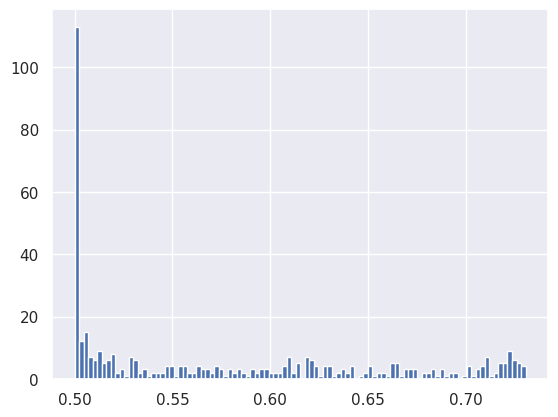

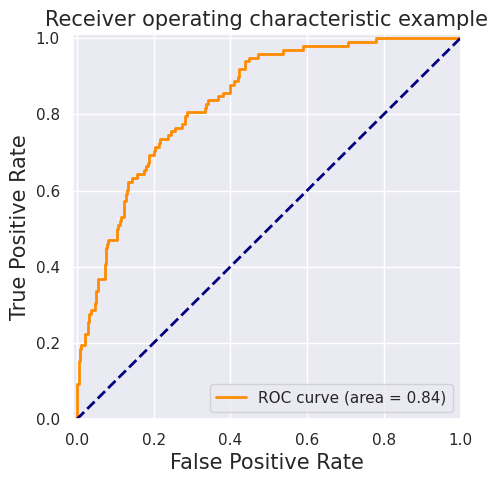

In [43]:
# plot histogram of predictions
plt.hist(preds, bins=100)
plt.show()

# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver operating characteristic example', fontsize=15)
plt.legend(loc="lower right")
plt.show()

05.06. um 21:30 - die submission Dataframes können nicht erstellt werden, da nach dem jetzigen Konzept das feature target bei den test daten fehlt. Sollte ich eine neue Klasse bzw. eine Methode dem PyTorch Lightning model hinzufügen - ähnlich etwa model.predict(test_data)?

06.06. 21:15 Die Gewichtung spielt wahrscheinlich enorm in die ROC curve rein.

In [46]:
%%time
for _ in range(3):
    trainer.test(model, dataloaders=test_loader, ckpt_path='best')

NotImplementedError: Support for `test_epoch_end` has been removed in v2.0.0. `MultiModalEfficientNet` implements this method. You can use the `on_test_epoch_end` hook instead. To access outputs, save them in-memory as instance attributes. You can find migration examples in https://github.com/Lightning-AI/lightning/pull/16520.

In [47]:
from glob import glob
submission = test_data[['target']]
submission.target = 0.0
for sub in glob(submission*.csv):
    submission.target += pd.read_csv(sub, index_col='image_name').target

submission.target -= submission.target.min()
submission.target /= submission.target.max()

submission.to_csv('submission_multi_modal.csv')

submission.hist(bins=100, log=True, alpha=0.75)

SyntaxError: invalid syntax (1179555249.py, line 4)

# Fazit 06.06.2023 @ 21:30
Rückblickend habe ich mich wohl in der Erstellung des Modells mit PyTorch Lightning verrannt. Über die letzten rund 20 Versionen habe ich verschiedene Möglichkeiteen ausprobiert, ein lernendes EfficientNetB0 Modell zu erstellen. Zusätzliche Schwierigkeit war die ansatzweise Implementierung einer Berücksichtigung der Gewichtung einzelner Samples aus der Mehrheitsklasse. Dies hat letztlich nicht wirklich funktioniert, da das MultiModalEfficientNet nun Werte zwischen 0.5 und 1 ausgibt, statt der sinnvollen 0.0. 

Über den Projektverlauf hinweg sind außerdem verschiedene Möglichkeiten und Funktionen zur Testung / predict() von Beispielbildern entstanden, die allerdings nicht in der finalen Version landeten. Zugegeben, hätte ich mir statt freizeitlichem Wasserrettungsdienst mehr Zeit nehmen können und so die Projektstruktur übersichtlicher, bzw. die Objektorientierung mehr in den Vordergrund gerückt (Erstellung Datasets mit df_sampled oder train_data, test_data in die Modellklasse schieben), dann wäre wohl auch eine Submission geglückt. Denn gerade dieses Ziel wurde bei beiden Modellen atemberaubend verfehlt. Nichtsdestoweniger nehme ich aus dem Projekt mit:
- Code und Abläufe zwischen den PyTorch Lightning Modulen und Methoden in irgendeiner Form zu visualisieren hilft ungemein (Schmierzettel oder Samsung Notes)
- Konstanten hätte ich lieber gleich zu Anfang deklarieren sollen, statt einzeln zum Beispiel die Anzahl der Epochen oder Lernrate in jeder Zelle zu ändern
- Klassencode besser recyclen (in bestimmter Form bei den Modellen geglückt)
- Nicht in den Details zu verlieren, kostet ungemein Zeit
- Mal Abstand nach etwas längeren Sessions zu gewinnen, schafft Klarheit im Betriebsnebel
- Ganz ehrlich: So nett Kaggle auch ist, lokale Ressourcen zu nutzen liegt mir mehr als Clouddienstleistungen - zumindest auf meinem jetzigen Erfahrungslevel; wahrscheinlich habe ich mich deswegen auch von 'nem Chromebook getrennt...

Genug Witz, meine Projektarbeit ist meiner Ansicht nach nicht perfekt, sondern eher mittelmäßig. Was ich vor 2 Wochen ehrlicherweise auch erwartet hatte - und sich nun auch bewahrheitet. Vor allem wenn die Anforderung "PyTorch" mit dem strukturierteren "PyTorch Lightning" abgewandelt wurde. Also würde ich nochmal von vorn anfangen, mache ich einiges 120 prozentig besser, performanter und schlanker als die Baustelle die hiermit abgegeben wurde.
